In [1]:
import sys
sys.path.append("..")

In [2]:
import numpy as np
import logging
import pickle
import glob

from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import RobustScaler
from sklearn.utils import check_random_state

from recnn.preprocessing import permute_by_pt
from recnn.preprocessing import extract

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,8)

In [3]:
def load_test(filename_train, filename_test):
    # Make training data
    print("Loading training data...")

    fd = open(filename_train, "rb")
    X, y = pickle.load(fd)
    fd.close()
    indices = np.random.permutation(len(X))
    size = min(80000, len(X))
    X = [X[i] for i in indices[:size]]
    y = [y[i] for i in indices[:size]]
    y = np.array(y)

    print("\tfilename = %s" % filename_train)
    print("\tX size = %d" % len(X))
    print("\ty size = %d" % len(y))

    # Preprocessing 
    print("Preprocessing...")
    X = [extract(permute_by_pt(jet)) for jet in X]
    tf = RobustScaler().fit(np.vstack([jet["content"] for jet in X]))

    for jet in X:
        jet["content"] = tf.transform(jet["content"])

    # Make test data 
    print("Loading test data...")

    fd = open(filename_test, "rb")
    X, y = pickle.load(fd)
    fd.close()
    y = np.array(y)

    print("\tfilename = %s" % filename_test)
    print("\tX size = %d" % len(X))
    print("\ty size = %d" % len(y))

    # Preprocessing 
    print("Preprocessing...")
    X = [extract(permute_by_pt(jet)) for jet in X]

    for jet in X:
        jet["content"] = tf.transform(jet["content"])
        
    return X, y

Loading training data...
	filename = ../data/z/anti-kt/antikt-train.pickle-py27-kt
	X size = 58946
	y size = 58946
Preprocessing...
Loading test data...
	filename = ../data/z/anti-kt/antikt-test.pickle-py27-kt
	X size = 20000
	y size = 20000
Preprocessing...
Loading ../models/trimming/z-kt-2.pickle
(0.79203438500000001, '../models/trimming/z-kt-2.pickle')
Loading ../models/trimming/z-kt-1.pickle


/home/gilles/anaconda3/envs/hep/lib/python2.7/site-packages/ipykernel/__main__.py:35: RuntimeWarning: divide by zero encountered in divide
/home/gilles/anaconda3/envs/hep/lib/python2.7/site-packages/ipykernel/__main__.py:37: RuntimeWarning: divide by zero encountered in divide


(0.79177385499999997, '../models/trimming/z-kt-1.pickle')
Loading ../models/trimming/z-kt-3.pickle
(0.79401212499999985, '../models/trimming/z-kt-3.pickle')
Loading ../models/trimming/z-kt-5.pickle
(0.79384737000000005, '../models/trimming/z-kt-5.pickle')
Loading ../models/trimming/z-kt-4.pickle
(0.79241799499999999, '../models/trimming/z-kt-4.pickle')
roc_auc(kt) = 0.7928 +- 0.0009
Loading training data...
	filename = ../data/z/anti-kt/antikt-train.pickle-py27-kt-trimmed
	X size = 58946
	y size = 58946
Preprocessing...
Loading test data...
	filename = ../data/z/anti-kt/antikt-test.pickle-py27-kt-trimmed
	X size = 20000
	y size = 20000
Preprocessing...
Loading ../models/trimming/z-kt-trimmed-7.pickle
(0.787318615, '../models/trimming/z-kt-trimmed-7.pickle')
Loading ../models/trimming/z-kt-trimmed-1.pickle
(0.77651548500000001, '../models/trimming/z-kt-trimmed-1.pickle')
Loading ../models/trimming/z-kt-trimmed-2.pickle
(0.79236265500000003, '../models/trimming/z-kt-trimmed-2.pickle')
Lo

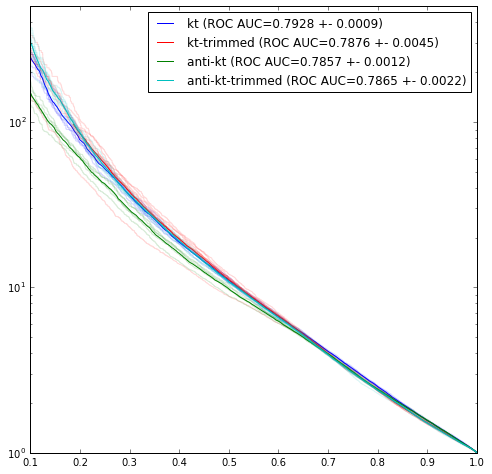

In [9]:
from recnn.recnn import grnn_predict_simple
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import glob
from scipy import interp


def predict(X, filename):
    fd = open(f, "rb")
    params = pickle.load(fd)
    fd.close()
    
    y_pred = grnn_predict_simple(params, X)
    
    return y_pred


for s, color in [("kt", "b"), ("kt-trimmed", "r"), ("anti-kt", "g"), ("anti-kt-trimmed", "c")]:  
    X, y = load_test("../data/z/anti-kt/antikt-train.pickle-py27-%s" % s,
                     "../data/z/anti-kt/antikt-test.pickle-py27-%s" % s) 

    inv_fprs = []
    base_tpr = np.linspace(0.1, 1, 301)
    rocs = []

    for f in glob.glob("../models/trimming/z-%s-[0-9]*.pickle" % s):
        print("Loading %s" % f)
        
        y_pred = predict(X, f)
        rocs.append(roc_auc_score(y, y_pred))
        
        print(rocs[-1], f)

        fpr, tpr, _ = roc_curve(y, y_pred)
        plt.plot(tpr, 1. / fpr, color, alpha=0.15)
        
        inv_fpr = interp(base_tpr, tpr, 1. / fpr)
        inv_fprs.append(inv_fpr)
                 
    inv_fprs = np.array(inv_fprs)
    mean_inv_fprs = inv_fprs.mean(axis=0)

    plt.plot(base_tpr, mean_inv_fprs, color, 
             label="%s (ROC AUC=%.4f +- %.4f)" % (s, np.mean(rocs), np.std(rocs)))
    
    print("roc_auc(%s) = %.4f +- %.4f" % (s, np.mean(rocs), np.std(rocs)))

plt.xlim([0.1, 1.0])
plt.ylim(1, 500)
plt.yscale("log")
plt.legend(loc="best")
plt.show()

Loading training data...
	filename = ../data/z/anti-kt/antikt-train.pickle-py27-kt
	X size = 58946
	y size = 58946
Preprocessing...
Loading test data...
	filename = ../data/z/anti-kt/antikt-test.pickle-py27-kt-trimmed
	X size = 20000
	y size = 20000
Preprocessing...
Loading ../models/trimming/z-kt-2.pickle
(0.77801845000000003, '../models/trimming/z-kt-2.pickle')
Loading ../models/trimming/z-kt-1.pickle


/home/gilles/anaconda3/envs/hep/lib/python2.7/site-packages/ipykernel/__main__.py:36: RuntimeWarning: divide by zero encountered in divide
/home/gilles/anaconda3/envs/hep/lib/python2.7/site-packages/ipykernel/__main__.py:38: RuntimeWarning: divide by zero encountered in divide


(0.78307228500000003, '../models/trimming/z-kt-1.pickle')
Loading ../models/trimming/z-kt-3.pickle
(0.7826739250000001, '../models/trimming/z-kt-3.pickle')
Loading ../models/trimming/z-kt-5.pickle
(0.782560115, '../models/trimming/z-kt-5.pickle')
Loading ../models/trimming/z-kt-4.pickle
(0.78266064499999999, '../models/trimming/z-kt-4.pickle')
roc_auc(kt) = 0.7818 +- 0.0019
Loading training data...
	filename = ../data/z/anti-kt/antikt-train.pickle-py27-kt-trimmed
	X size = 58946
	y size = 58946
Preprocessing...
Loading test data...
	filename = ../data/z/anti-kt/antikt-test.pickle-py27-kt
	X size = 20000
	y size = 20000
Preprocessing...
Loading ../models/trimming/z-kt-trimmed-7.pickle
(0.75473131999999998, '../models/trimming/z-kt-trimmed-7.pickle')
Loading ../models/trimming/z-kt-trimmed-1.pickle
(0.76582054499999996, '../models/trimming/z-kt-trimmed-1.pickle')
Loading ../models/trimming/z-kt-trimmed-2.pickle
(0.76010137499999997, '../models/trimming/z-kt-trimmed-2.pickle')
Loading ../

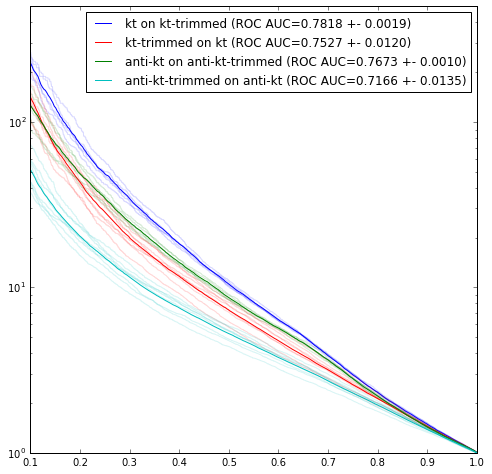

In [8]:
from recnn.recnn import grnn_predict_simple
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import glob
from scipy import interp


def predict(X, filename):
    fd = open(f, "rb")
    params = pickle.load(fd)
    fd.close()
    
    y_pred = grnn_predict_simple(params, X)
    
    return y_pred


for s1, s2, color in [("kt", "kt-trimmed", "b"), ("kt-trimmed", "kt", "r"), 
                      ("anti-kt", "anti-kt-trimmed", "g"), ("anti-kt-trimmed", "anti-kt", "c")]:  
    X, y = load_test("../data/z/anti-kt/antikt-train.pickle-py27-%s" % s1,
                     "../data/z/anti-kt/antikt-test.pickle-py27-%s" % s2) 

    inv_fprs = []
    base_tpr = np.linspace(0.1, 1, 301)
    rocs = []

    for f in glob.glob("../models/trimming/z-%s-[0-9]*.pickle" % s1):
        print("Loading %s" % f)
        
        y_pred = predict(X, f)
        rocs.append(roc_auc_score(y, y_pred))
        
        print(rocs[-1], f)

        fpr, tpr, _ = roc_curve(y, y_pred)
        plt.plot(tpr, 1. / fpr, color, alpha=0.15)
        
        inv_fpr = interp(base_tpr, tpr, 1. / fpr)
        inv_fprs.append(inv_fpr)
                 
    inv_fprs = np.array(inv_fprs)
    mean_inv_fprs = inv_fprs.mean(axis=0)

    plt.plot(base_tpr, mean_inv_fprs, color, 
             label="%s on %s (ROC AUC=%.4f +- %.4f)" % (s1, s2, np.mean(rocs), np.std(rocs)))
    
    print("roc_auc(%s) = %.4f +- %.4f" % (s1, np.mean(rocs), np.std(rocs)))

plt.xlim([0.1, 1.0])
plt.ylim(1, 500)
plt.yscale("log")
plt.legend(loc="best")
plt.show()

Loading training data...
	filename = ../data/w-vs-qcd/anti-kt/antikt-train.pickle-py27-kt
	X size = 80000
	y size = 80000
Preprocessing...
Loading test data...
	filename = ../data/w-vs-qcd/anti-kt/antikt-test.pickle-py27-kt
	X size = 20000
	y size = 20000
Preprocessing...
Loading ../models/trimming/w-kt-4.pickle
(0.88735471499999985, '../models/trimming/w-kt-4.pickle')
Loading ../models/trimming/w-kt-3.pickle


/home/gilles/anaconda3/envs/hep/lib/python2.7/site-packages/ipykernel/__main__.py:35: RuntimeWarning: divide by zero encountered in divide
/home/gilles/anaconda3/envs/hep/lib/python2.7/site-packages/ipykernel/__main__.py:37: RuntimeWarning: divide by zero encountered in divide


(0.88800591500000003, '../models/trimming/w-kt-3.pickle')
Loading ../models/trimming/w-kt-1.pickle
(0.88936491500000003, '../models/trimming/w-kt-1.pickle')
Loading ../models/trimming/w-kt-5.pickle
(0.8881299800000001, '../models/trimming/w-kt-5.pickle')
Loading ../models/trimming/w-kt-2.pickle
(0.88570679499999994, '../models/trimming/w-kt-2.pickle')
roc_auc(kt) = 0.8877 +- 0.0012
Loading training data...
	filename = ../data/w-vs-qcd/anti-kt/antikt-train.pickle-py27-kt-trimmed
	X size = 80000
	y size = 80000
Preprocessing...
Loading test data...
	filename = ../data/w-vs-qcd/anti-kt/antikt-test.pickle-py27-kt-trimmed
	X size = 20000
	y size = 20000
Preprocessing...
Loading ../models/trimming/w-kt-trimmed-1.pickle
(0.8859650899999999, '../models/trimming/w-kt-trimmed-1.pickle')
Loading ../models/trimming/w-kt-trimmed-4.pickle
(0.88470149999999992, '../models/trimming/w-kt-trimmed-4.pickle')
Loading ../models/trimming/w-kt-trimmed-6.pickle
(0.8840711349999999, '../models/trimming/w-kt-tr

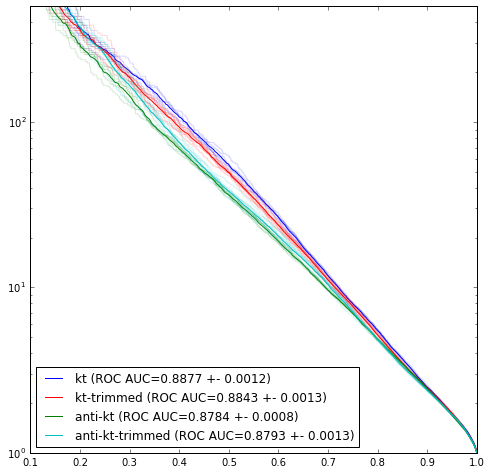

In [10]:
from recnn.recnn import grnn_predict_simple
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import glob
from scipy import interp


def predict(X, filename):
    fd = open(f, "rb")
    params = pickle.load(fd)
    fd.close()
    
    y_pred = grnn_predict_simple(params, X)
    
    return y_pred


for s, color in [("kt", "b"), ("kt-trimmed", "r"), ("anti-kt", "g"), ("anti-kt-trimmed", "c")]:  
    X, y = load_test("../data/w-vs-qcd/anti-kt/antikt-train.pickle-py27-%s" % s,
                     "../data/w-vs-qcd/anti-kt/antikt-test.pickle-py27-%s" % s) 

    inv_fprs = []
    base_tpr = np.linspace(0.1, 1, 301)
    rocs = []

    for f in glob.glob("../models/trimming/w-%s-[0-9]*.pickle" % s):
        print("Loading %s" % f)
        
        y_pred = predict(X, f)
        rocs.append(roc_auc_score(y, y_pred))
        
        print(rocs[-1], f)

        fpr, tpr, _ = roc_curve(y, y_pred)
        plt.plot(tpr, 1. / fpr, color, alpha=0.15)
        
        inv_fpr = interp(base_tpr, tpr, 1. / fpr)
        inv_fprs.append(inv_fpr)
                 
    inv_fprs = np.array(inv_fprs)
    mean_inv_fprs = inv_fprs.mean(axis=0)

    plt.plot(base_tpr, mean_inv_fprs, color, 
             label="%s (ROC AUC=%.4f +- %.4f)" % (s, np.mean(rocs), np.std(rocs)))
    
    print("roc_auc(%s) = %.4f +- %.4f" % (s, np.mean(rocs), np.std(rocs)))

plt.xlim([0.1, 1.0])
plt.ylim(1, 500)
plt.yscale("log")
plt.legend(loc="best")
plt.show()

Loading training data...
	filename = ../data/w-vs-qcd/anti-kt/antikt-train.pickle-py27-kt
	X size = 80000
	y size = 80000
Preprocessing...
Loading test data...
	filename = ../data/w-vs-qcd/anti-kt/antikt-test.pickle-py27-kt-trimmed
	X size = 20000
	y size = 20000
Preprocessing...
Loading ../models/trimming/w-kt-4.pickle
(0.87526055499999988, '../models/trimming/w-kt-4.pickle')
Loading ../models/trimming/w-kt-3.pickle


/home/gilles/anaconda3/envs/hep/lib/python2.7/site-packages/ipykernel/__main__.py:36: RuntimeWarning: divide by zero encountered in divide
/home/gilles/anaconda3/envs/hep/lib/python2.7/site-packages/ipykernel/__main__.py:38: RuntimeWarning: divide by zero encountered in divide


(0.87652976500000002, '../models/trimming/w-kt-3.pickle')
Loading ../models/trimming/w-kt-1.pickle
(0.8762535199999999, '../models/trimming/w-kt-1.pickle')
Loading ../models/trimming/w-kt-5.pickle
(0.87700217999999996, '../models/trimming/w-kt-5.pickle')
Loading ../models/trimming/w-kt-2.pickle
(0.87327817500000005, '../models/trimming/w-kt-2.pickle')
roc_auc(kt) = 0.8757 +- 0.0013
Loading training data...
	filename = ../data/w-vs-qcd/anti-kt/antikt-train.pickle-py27-kt-trimmed
	X size = 80000
	y size = 80000
Preprocessing...
Loading test data...
	filename = ../data/w-vs-qcd/anti-kt/antikt-test.pickle-py27-kt
	X size = 20000
	y size = 20000
Preprocessing...
Loading ../models/trimming/w-kt-trimmed-1.pickle
(0.84228183500000009, '../models/trimming/w-kt-trimmed-1.pickle')
Loading ../models/trimming/w-kt-trimmed-4.pickle
(0.86130261000000008, '../models/trimming/w-kt-trimmed-4.pickle')
Loading ../models/trimming/w-kt-trimmed-6.pickle
(0.85571019000000004, '../models/trimming/w-kt-trimmed-

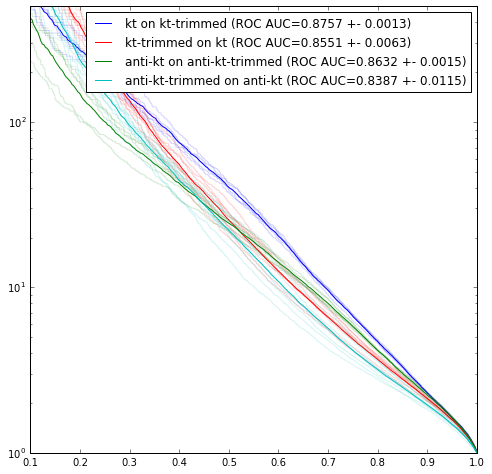

In [11]:
from recnn.recnn import grnn_predict_simple
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import glob
from scipy import interp


def predict(X, filename):
    fd = open(f, "rb")
    params = pickle.load(fd)
    fd.close()
    
    y_pred = grnn_predict_simple(params, X)
    
    return y_pred


for s1, s2, color in [("kt", "kt-trimmed", "b"), ("kt-trimmed", "kt", "r"), 
                      ("anti-kt", "anti-kt-trimmed", "g"), ("anti-kt-trimmed", "anti-kt", "c")]:  
    X, y = load_test("../data/w-vs-qcd/anti-kt/antikt-train.pickle-py27-%s" % s1,
                     "../data/w-vs-qcd/anti-kt/antikt-test.pickle-py27-%s" % s2) 

    inv_fprs = []
    base_tpr = np.linspace(0.1, 1, 301)
    rocs = []

    for f in glob.glob("../models/trimming/w-%s-[0-9]*.pickle" % s1):
        print("Loading %s" % f)
        
        y_pred = predict(X, f)
        rocs.append(roc_auc_score(y, y_pred))
        
        print(rocs[-1], f)

        fpr, tpr, _ = roc_curve(y, y_pred)
        plt.plot(tpr, 1. / fpr, color, alpha=0.15)
        
        inv_fpr = interp(base_tpr, tpr, 1. / fpr)
        inv_fprs.append(inv_fpr)
                 
    inv_fprs = np.array(inv_fprs)
    mean_inv_fprs = inv_fprs.mean(axis=0)

    plt.plot(base_tpr, mean_inv_fprs, color, 
             label="%s on %s (ROC AUC=%.4f +- %.4f)" % (s1, s2, np.mean(rocs), np.std(rocs)))
    
    print("roc_auc(%s) = %.4f +- %.4f" % (s1, np.mean(rocs), np.std(rocs)))

plt.xlim([0.1, 1.0])
plt.ylim(1, 500)
plt.yscale("log")
plt.legend(loc="best")
plt.show()